In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os 
import cv2 as cv
import random

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Conv2D, Dense, MaxPooling2D, Flatten
import tensorflow as tf

In [4]:
#to prevent memory overflow error coaused by gpu, setup GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
#setup paths for folder structures
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [6]:
#make directories
os.makedirs(POS_PATH) #matching ones
os.makedirs(NEG_PATH) #non-matching ones
os.makedirs(ANC_PATH) #the ones with matched

In [ ]:
# uncompress tar gc for labelled faces in the wild dataset
!tar -xf lfw.tgz

In [7]:
#move images to negative folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [17]:
import uuid #to generate unique identification names for generated images
uuid.uuid1()

UUID('fa041ddb-5a1f-11ee-8d5e-18473dde6de0')

In [18]:
cap = cv.VideoCapture(0)# assigning webcam :- 0 for laptop
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[200:200+250,200:200+250,:] #we need to bring the frame size tibe the same as those in data//negative which is 250*250 px
    # collecting anchors
    if cv.waitKey(1) & 0XFF==ord('a'):
        # unique file name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv.imwrite(imgname,frame)
    
    # collecting positives
    if cv.waitKey(1) & 0XFF==ord('p'):
        # unique file name 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv.imwrite(imgname,frame)
    
    cv.imshow('Image Collection',frame)# to display image on screen
    # breaking and capturing
    if cv.waitKey(1) & 0XFF==ord('q'):
        break
        
cap.release()
cv.destroyAllWindows

<function destroyAllWindows>

In [7]:
frame.shape
# we need to bring the frame size tibe the same as those in data//negative which is 250*250 px
# reassign frame size in above loop itself

(250, 250, 3)

#manipulate next cell for better performance

#making of data pipelines

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(200)#grab everything inside the achor path that has .jpg extension
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(200)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(200)

In [20]:
dir_test = anchor.as_numpy_iterator() #how to iterate through the pipelines
dir_test.next()

b'data\\anchor\\4af3e63b-5a21-11ee-8158-18473dde6de0.jpg'

Preprocessing - scale and resize

In [6]:
def preprocess(file_path):
    #read file as byte scale
    byte_img = tf.io.read_file(file_path)
    #load it as img
    img = tf.io.decode_image(byte_img,expand_animations = False)
    #resize the img to 100*100*3 as prescribed in the siamese network
    img = tf.image.resize(img,(100,100))
    #scale between 0 and 1
    img = img/255.0
    return img

Create a labelled dataset

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) #creates a new dataset by combining anchor, positive, and a dataset of ones element-wise
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) #append the negatives below positives

In [8]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [10]:
samples = data.as_numpy_iterator() #samples is an iterator that would iterate throught the datset
example=samples.next()

In [9]:
# function where we will pass unpacked dataset as twins so that it preprecesses and scales the images as in preprocess func
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)
# for example: res=prepocess_twin(*samples.next()) where * is so that the unpacked tuple is pass and i dont have to unpack and pass each element separately

In [16]:
preprocess_twin(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.7017157 , 0.67034316, 0.6625    ],
         [0.7088235 , 0.67745095, 0.6696078 ],
         [0.7088235 , 0.67745095, 0.6696078 ],
         ...,
         [0.66568625, 0.65392154, 0.6343137 ],
         [0.6634804 , 0.6517157 , 0.63210785],
         [0.6637255 , 0.6519608 , 0.63235295]],
 
        [[0.7026961 , 0.67132354, 0.6634804 ],
         [0.7019608 , 0.67058825, 0.6627451 ],
         [0.70710784, 0.6757353 , 0.66789216],
         ...,
         [0.67156863, 0.6578431 , 0.6401961 ],
         [0.66544116, 0.6517157 , 0.6340686 ],
         [0.6607843 , 0.64705884, 0.62941176]],
 
        [[0.7117647 , 0.68039215, 0.672549  ],
         [0.7078431 , 0.6764706 , 0.66862744],
         [0.70490193, 0.6735294 , 0.66568625],
         ...,
         [0.67058825, 0.6509804 , 0.6392157 ],
         [0.66838235, 0.6487745 , 0.6370098 ],
         [0.6578431 , 0.6382353 , 0.62647057]],
 
        ...,
 
        [[0.4757353 , 0.42107844

In [10]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [11]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

training partition

In [12]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)#we will pass in batches of 16
train_data = train_data.prefetch(8)

In [13]:
train_data#(None(no of examples-16), 100, 100, None(3))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

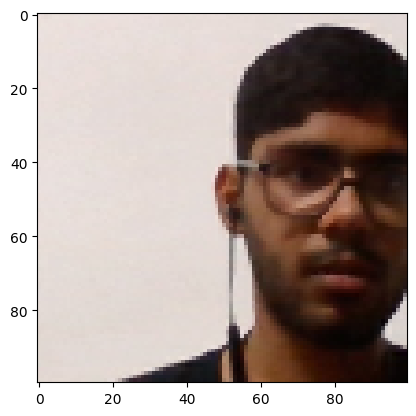

In [18]:
train_sample = train_data.as_numpy_iterator()
ts = train_sample.next()
ts[0].shape#(16, 100, 100, 3)#first batch
plt.imshow(ts[0][1])

testing partition

In [102]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [103]:
len(test_data)

8

In [59]:
test_data

<_TakeDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

1. Build Embedding Layer
2. Build Distance Layer(L1)
3. Make Siamese Network

Refer the archituecture for siamese neural network for facial recognition: 
https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

In [15]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final Embedding Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [16]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

Build Distance Layer

In [17]:
# Siamese L1 Disatnce class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__();
    
    # similarity calculator
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [18]:
l1 = L1Dist()

Make Siamese Model - combining 2 layers for a classification task

In [19]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_image', shape=(100,100,3))
    
    # Validation image in the network
    validation_image = Input(name='validation_image', shape=(100,100,3))
    
    # combine distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image], outputs=classifier, name='SiameseNetwork')

In [20]:
siamese_model = make_siamese_model()

In [21]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_image (InputLay  [(None, 100, 100, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_image[0][0]']    
                                                                                     

Setup Loss Optimizer

In [22]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [23]:
opt = tf.optimizers.Adam(1e-4)

Establish Checkpoints

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Build Train-Step function
for each batch passed:-
1. Make a prediction
2. Calculate loss
3. Derive Gradients
4. Calculate new weights and apply

In [25]:
@tf.function # compiles a function into a callable Tensorflow graph
def train_step(batch):
    # to record the derivatives at every steps for each batch passed
    with tf.GradientTape() as tape: 
        # from dataset
        # grab anchor and positive/negative columns
        X = batch[:2]
        # get the label, 1 if pos, 0 if negative
        y = batch[2]
        
        # forward pass prediction
        yhat = siamese_model(X, training=True) # some layers activate only during actual training so actually have training
        # calculate loss
        loss = binary_cross_loss(y,yhat) # (label,prediction)
    print(loss)
    
    # calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables) # computes the gradients of the loss with respect to the trainable variables(weights) of the Siamese model
    
    # calculate updtaed weights and aaply to the siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables)) # calculating and propagating new weights using the Adam optimizer, which is a variant of gradient descent
    
    return loss

Training loops

In [26]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [27]:
EPOCHS = 50

In [28]:
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
18/18 [==============================] - 498s 27s/step

 Epoch 2/50
18/18 [==============================] - 466s 26s/step

 Epoch 3/50
18/18 [==============================] - 454s 25s/step

 Epoch 4/50
18/18 [==============================] - 459s 26s/step

 Epoch 5/50
18/18 [==============================] - 450s 25s/step

 Epoch 6/50
18/18 [==============================] - 446s 25s/step

 Epoch 7/50
18/18 [==============================] - 454s 25s/step

 Epoch 8/50
18/18 [==============================] - 493s 27s/step

 Epoch 9/50
18/18 [==============================] - 503s 28s/step

 Epoch 10/50
18/18 [==============================] - 496s 28s/step

 Epoch 11/50
18/18 [==============================] - 472s 26s/step

 Epoch 12/50
18/18 [==============================] - 473s 26s/step

 Epoch 13/50
18/18 [======

Model Evaluation

In [30]:
from tensorflow.keras.metrics import Precision, Recall
# recall = tp/(tp+fp)
# precision = tp/(tp+fn)

In [104]:
# for each batch of test data, unpacking gives
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [73]:
test_data.as_numpy_iterator().next()

(array([[[0.904902  , 0.8656863 , 0.85784316],
         [0.90392154, 0.86470586, 0.8568627 ],
         [0.9019608 , 0.8656863 , 0.8490196 ],
         ...,
         [0.8786765 , 0.8355392 , 0.8276961 ],
         [0.87352943, 0.8303922 , 0.82254905],
         [0.872549  , 0.82941175, 0.8215686 ]],
 
        [[0.90343136, 0.8642157 , 0.85637254],
         [0.9117647 , 0.87352943, 0.8627451 ],
         [0.9019608 , 0.8666667 , 0.84705883],
         ...,
         [0.8779412 , 0.8367647 , 0.82598037],
         [0.87352943, 0.83235294, 0.8215686 ],
         [0.87352943, 0.8352941 , 0.8245098 ]],
 
        [[0.90588236, 0.8666667 , 0.85882354],
         [0.8997549 , 0.8637255 , 0.84632355],
         [0.8990196 , 0.8637255 , 0.84411764],
         ...,
         [0.8666667 , 0.83137256, 0.8117647 ],
         [0.87058824, 0.8352941 , 0.8156863 ],
         [0.86764705, 0.83235294, 0.8127451 ]],
 
        ...,
 
        [[0.65710783, 0.60612744, 0.5747549 ],
         [0.88504905, 0.83406866, 0.80906

In [36]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_image (InputLay  [(None, 100, 100, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_image[0][0]']    
                                                                                     

In [105]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 3s 3s/step


array([[9.9934959e-01],
       [9.9979234e-01],
       [1.0000000e+00],
       [9.9995804e-01],
       [9.9913210e-01],
       [9.9971324e-01],
       [9.9965340e-01],
       [9.9999976e-01],
       [7.2446267e-09],
       [9.9998885e-01],
       [2.2577289e-08],
       [3.0657364e-07],
       [9.9999189e-01],
       [1.3125830e-06],
       [1.0000000e+00],
       [3.8712424e-05]], dtype=float32)

In [106]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0]

In [107]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

In [109]:
# create a metric object
m = Recall()
# calculating the recall value
# m.update_status(y_true, y_hat)
# return recall result
m.result().numpy()

0.0

Visualize Result

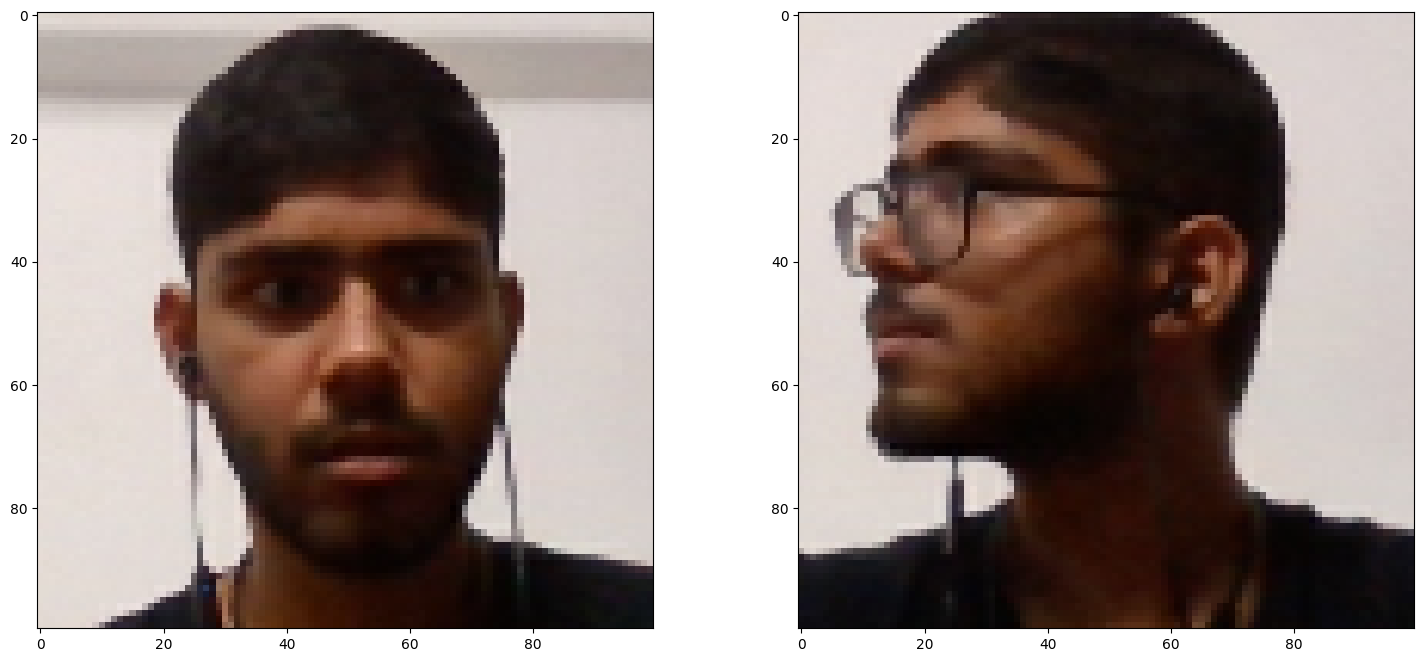

In [110]:
plt.figure(figsize=(18,8))
# first subplot
plt.subplot(1,2,1)#(num_rows,num_cols,index)
plt.imshow(test_input[0])
# second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

Viz Results

In [111]:
# save weights
siamese_model.save('siamese_model.h5')

C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
# reload model
model = tf.keras.models.load_model('siamese_model.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [113]:
model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


array([[9.9934959e-01],
       [9.9979234e-01],
       [1.0000000e+00],
       [9.9995804e-01],
       [9.9913210e-01],
       [9.9971324e-01],
       [9.9965340e-01],
       [9.9999976e-01],
       [7.2446267e-09],
       [9.9998885e-01],
       [2.2577289e-08],
       [3.0657364e-07],
       [9.9999189e-01],
       [1.3125830e-06],
       [1.0000000e+00],
       [3.8712424e-05]], dtype=float32)

In [114]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_image (InputLay  [(None, 100, 100, 3)]        0         []                            
 er)                                                                                              
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validation_image[0][0]']    
                                                                                     

Real Time Test

In [117]:
def verify(model,detection_threshold,verification_threshold):
    # build results array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        
        # make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        # expand dims is to add an extra dimension along axis=1(columns) so that its shape is from (2,...) to (2,1,..), basically that extra 1 is necessary while dealing with batch dimensions 
        results.append(result)
        
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

OpenCV realtime verification

In [126]:
cap = cv.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[200:200+250,200:200+250,:]
    cv.imshow('Verification', frame)
    
    # Verification Trigger
    if cv.waitKey(10) & 0xFF==ord('v'):
        # save input image to application_data/input_image
        cv.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        # Run Verification
        results, verified = verify(model,0.7,0.7)
        print(verified)
    
    if cv.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 295ms/step
True
1/1 [==============================] - 0s 300ms/step
False
1/1 [==============================] - 0s 402ms/step
False
1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 438ms/step
True
1/1 [==============================] - 0s 494ms/step
True
1/1 [==============================] - 0s 434ms/step
False
1/1 [==============================] - 1s 506ms/step


1/1 [==============================] - 1s 561ms/step
True
1/1 [==============================] - 1s 500ms/step
True
1/1 [==============================] - 0s 458ms/step
True
1/1 [==============================] - 0s 473ms/step


1/1 [==============================] - 1s 507ms/step
False


In [ ]:
np.sum(np.squeeze(results)>0.5)